#install important packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install tensorflow sklearn pandas numpy matplotlib nltk

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [4]:
with open("/content/drive/MyDrive/Chatbot_ds/Intent.json") as diabetes_dataset:
  dataset = json.load(diabetes_dataset)

In [5]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [6]:
[tags, inputs, responses] = processing_json_dataset(dataset)

In [7]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [8]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [9]:
dataset = dataset.sample(frac=1)

In [10]:
dataset.head()

,inputs,tags
130,Why not,PodBayDoorResponse
67,Wasn't meant for you,NotTalking2U
136,Can you prove you are self-aware,SelfAware
75,Know what I mean,UnderstandQuery
23,Good thanks! This is Adam,CourtesyGreetingResponse


In [11]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [12]:
dataset.head()

,inputs,tags
130,"[w, h, y, , n, o, t]",PodBayDoorResponse
67,"[w, a, s, n, t, , m, e, a, n, t, , f, o, r, ...",NotTalking2U
136,"[c, a, n, , y, o, u, , p, r, o, v, e, , y, ...",SelfAware
75,"[k, n, o, w, , w, h, a, t, , i, , m, e, a, n]",UnderstandQuery
23,"[g, o, o, d, , t, h, a, n, k, s, , t, h, i, ...",CourtesyGreetingResponse


In [13]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [14]:
dataset.head()

,inputs,tags
130,why not,PodBayDoorResponse
67,wasnt meant for you,NotTalking2U
136,can you prove you are selfaware,SelfAware
75,know what i mean,UnderstandQuery
23,good thanks this is adam,CourtesyGreetingResponse


In [15]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [16]:
len(features[0])

9

In [17]:
input_shape = features.shape[1]
print(input_shape)

9


In [18]:
features.shape

(143, 9)

In [19]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  117
output length:  22


In [20]:
tokenizer.word_index

{'you': 1,
 'is': 2,
 'me': 3,
 'are': 4,
 'i': 5,
 'what': 6,
 'the': 7,
 'can': 8,
 'thanks': 9,
 'do': 10,
 'name': 11,
 'please': 12,
 'am': 13,
 'your': 14,
 'a': 15,
 'tell': 16,
 'pod': 17,
 'bay': 18,
 'door': 19,
 'adam': 20,
 'bella': 21,
 'open': 22,
 'not': 23,
 'prove': 24,
 'real': 25,
 'time': 26,
 'to': 27,
 'why': 28,
 'my': 29,
 'how': 30,
 'gossip': 31,
 'talking': 32,
 'it': 33,
 'know': 34,
 'good': 35,
 'call': 36,
 'see': 37,
 'wasnt': 38,
 'this': 39,
 'user': 40,
 'goodbye': 41,
 'great': 42,
 'bye': 43,
 'very': 44,
 'who': 45,
 'thank': 46,
 'hello': 47,
 'for': 48,
 'joke': 49,
 'there': 50,
 'any': 51,
 'some': 52,
 'ok': 53,
 'hi': 54,
 'have': 55,
 'conscious': 56,
 'doing': 57,
 'well': 58,
 'clever': 59,
 'girl': 60,
 'quiet': 61,
 'will': 62,
 'selfaware': 63,
 'understand': 64,
 'hola': 65,
 'hya': 66,
 'hope': 67,
 'fuck': 68,
 'saying': 69,
 'be': 70,
 'up': 71,
 'genious': 72,
 'whats': 73,
 'anyone': 74,
 'in': 75,
 'camera': 76,
 'intelligent': 7

In [21]:
m = Sequential()
m.add(Input(shape=(features.shape[1])))
m.add(Embedding(vocabulary + 1,100))
m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001)))
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [22]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-12-18 21:41:43--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-18 21:41:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-12-18 21:44:22 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [23]:
m.layers

In [24]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [25]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [27]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [28]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [29]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 100)            11800     
                                                                 
 conv1d (Conv1D)             (None, 5, 32)             16032     
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [30]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [31]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 [==============================] - 7s 27ms/step - loss: 3.0973 - accuracy: 0.0490
Epoch 2/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.0891 - accuracy: 0.0629
Epoch 3/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.0930 - accuracy: 0.0350
Epoch 4/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.0914 - accuracy: 0.0909
Epoch 5/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.0833 - accuracy: 0.0490
Epoch 6/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.0735 - accuracy: 0.0699
Epoch 7/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.0817 - accuracy: 0.0769
Epoch 8/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.0733 - accuracy: 0.1049
Epoch 9/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.0720 - accuracy: 0.0629
Epoch 10/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.0526 - accuracy: 0.1329
Epoch 11/

In [32]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

<ipython-input-32-9446446f8df0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


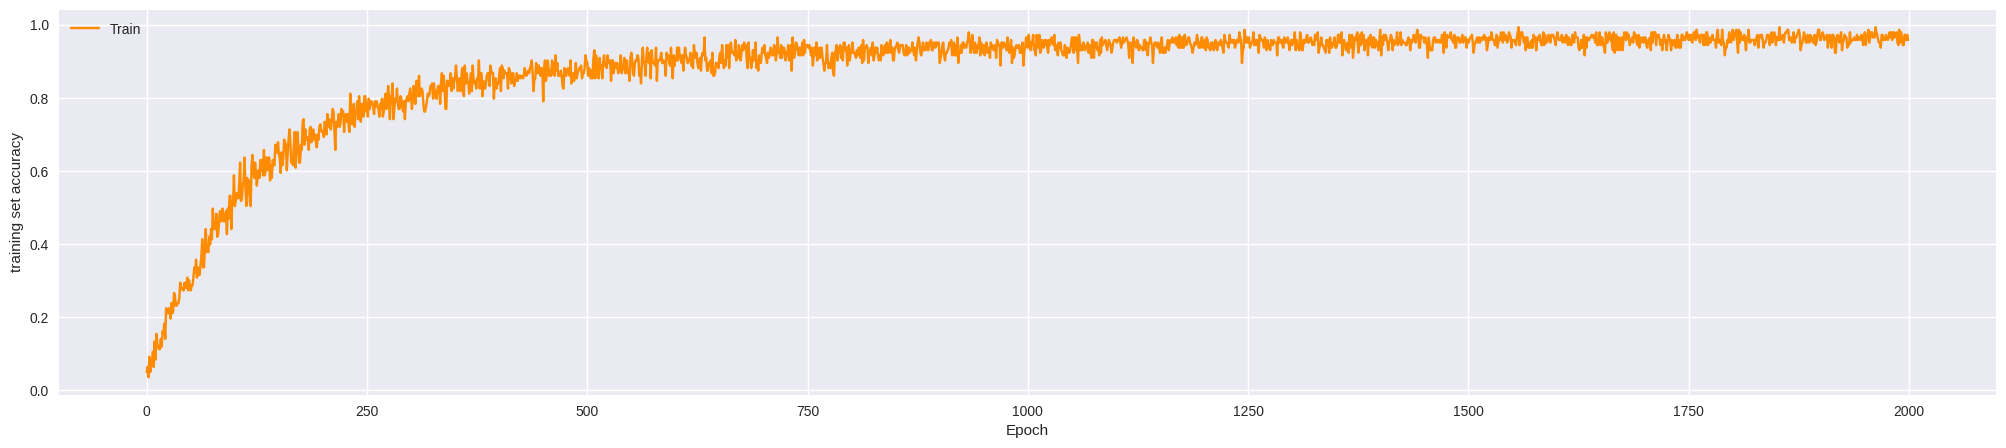

In [33]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

<ipython-input-32-9446446f8df0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


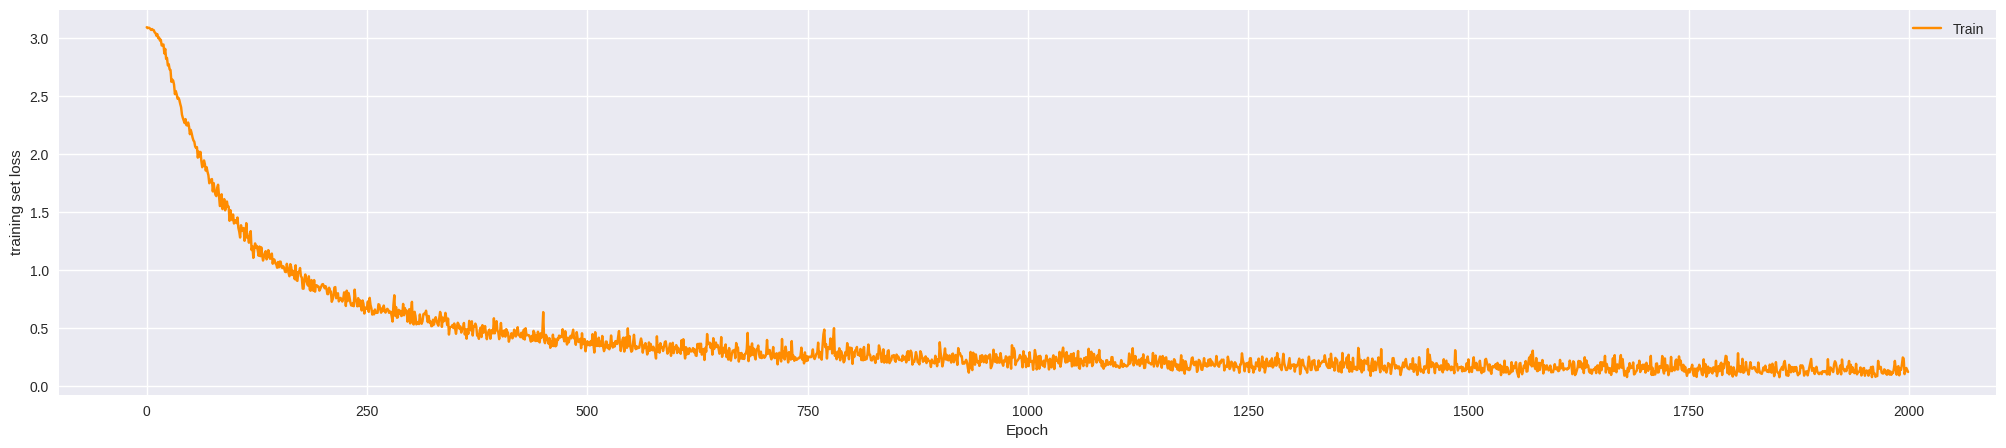

In [34]:
draw_plot(history_training.history['loss'],'training set loss' )

In [35]:
m.evaluate(features, labels, batch_size = 64)

3/3 [==============================] - 1s 10ms/step - loss: 0.0480 - accuracy: 0.9930


[0.04797590896487236, 0.9930070042610168]

In [36]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [37]:
list_que = ["hello", "i am kaled","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)

you: hello
1/1 [==============================] - 1s 945ms/step
Hola human, please tell me your GeniSys user
you: i am kaled
1/1 [==============================] - 0s 24ms/step
No problem!
you: what is my name?
1/1 [==============================] - 0s 24ms/step
Your name is  <HUMAN>, how can I help you?
you: what is your name?
1/1 [==============================] - 0s 26ms/step
Call me Geni
you: tell me please, what is your name?
1/1 [==============================] - 0s 26ms/step
That is an difficult question, can you prove that you are?
